### Đọc dữ liệu

In [ ]:
# =========================================================
# IMPORT THƯ VIỆN
# =========================================================
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Hiển thị đẹp trong notebook
sns.set(style="whitegrid", font_scale=1.2)

# =========================================================
# ĐỌC FILE CSV
# =========================================================
path = r"/content/drive/MyDrive/project2/project2a/dantri_preprocessed.csv"
data = pd.read_csv(path, encoding="utf-8")

# =========================================================
# XEM TỔNG QUAN DỮ LIỆU
# =========================================================
print(" Kích thước dữ liệu:", data.shape)
print(" Các cột có trong file:")
print(list(data.columns))

print("5 dòng đầu:")
print(data.head())

print("Kiểm tra giá trị thiếu:")
print(data.isnull().sum())


 Kích thước dữ liệu: (7278, 3)
 Các cột có trong file:
['category', 'content', 'clean_text']
5 dòng đầu:
  category                                            content  \
0  Thời sự  Chiếc ô tô đang di chuyển bất ngờ bốc cháy ngù...   
1  Thời sự  Khu vực Bắc Bộ duy trì trạng thái thời tiết mư...   
2  Thời sự  Khoảng 17h40 ngày 11/10, một vụ cháy lớn xảy r...   
3  Thời sự  Ngày 11/10, Tổng Bí thư Tô Lâm và đoàn đại biể...   
4  Thời sự  Trao đổi với phóng viênDân trítối 11/10, ông H...   

                                          clean_text  
0  ô_tô di_chuyển bất_ngờ bốc cháy ngùn_ngụt đườn...  
1  khu_vực bắc_bộ duy_trì trạng_thái thời_tiết mư...  
2  h ngày_một vụ cháy xảy bãi xe cửa_hàng xăng_dầ...  
3  tổng_bí_thư tô_lâm đoàn đại_biểu hà_nội kết_th...  
4  trao_đổi phóng viêndân_trítối hà tuấn chủ_tịch...  
Kiểm tra giá trị thiếu:
category      0
content       0
clean_text    0
dtype: int64


In [ ]:
data["clean_text_length"] = data["clean_text"].astype(str).apply(len)
print(" Độ dài trung bình của bài viết:", round(data["clean_text_length"].mean(), 2))


 Độ dài trung bình của bài viết: 2402.1


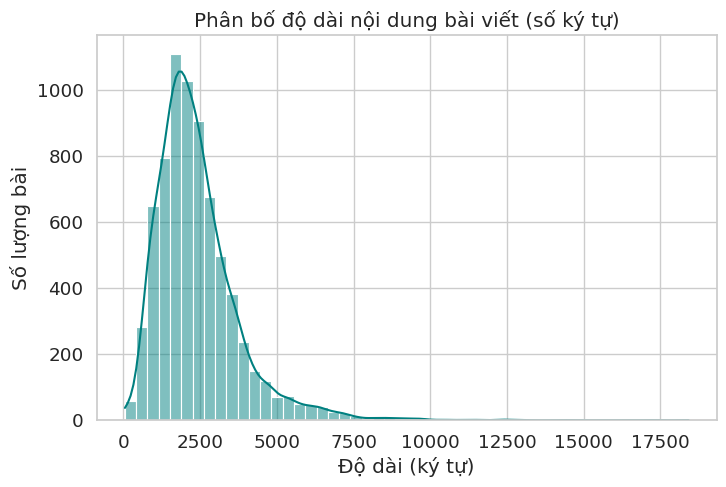

In [ ]:
plt.figure(figsize=(8,5))
sns.histplot(data["clean_text_length"], bins=50, kde=True, color="teal")
plt.title("Phân bố độ dài nội dung bài viết (số ký tự)")
plt.xlabel("Độ dài (ký tự)")
plt.ylabel("Số lượng bài")
plt.show()


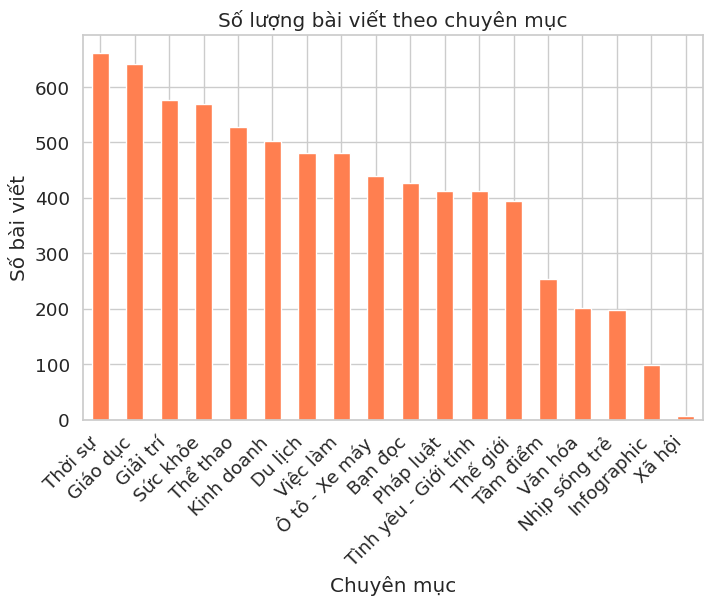

In [ ]:
plt.figure(figsize=(8,5))
data["category"].value_counts().plot(kind='bar', color='coral')
plt.title("Số lượng bài viết theo chuyên mục")
plt.xlabel("Chuyên mục")
plt.ylabel("Số bài viết")
plt.xticks(rotation=45, ha='right')
plt.show()


In [ ]:
!pip install wordcloud


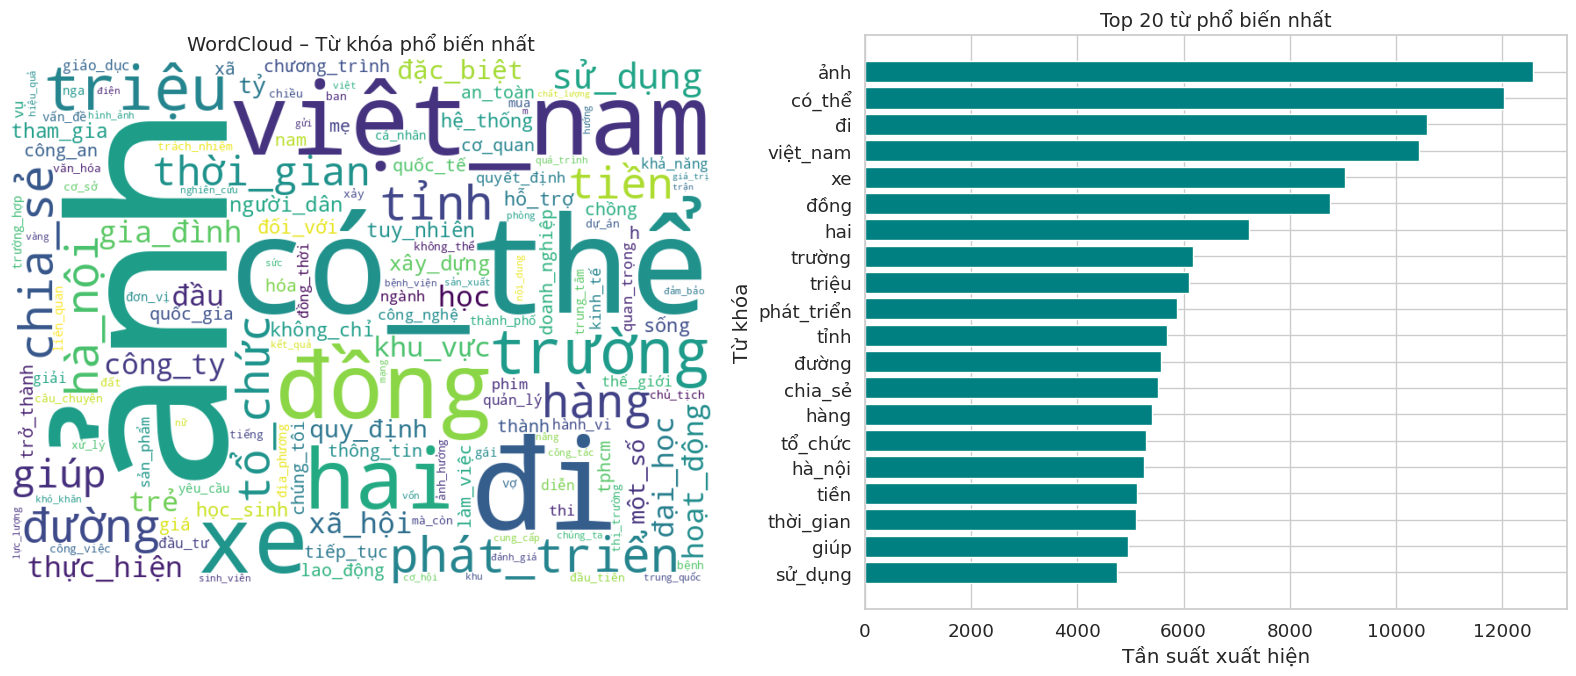

In [ ]:
# =========================================================
#IMPORT THƯ VIỆN
# =========================================================
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import Counter

# =========================================================
# GỘP TOÀN BỘ NỘI DUNG VĂN BẢN
# =========================================================
text_all = " ".join(data["clean_text"].astype(str).tolist())

# =========================================================
# TÍNH TẦN SUẤT TỪ
# =========================================================
words = text_all.split()
word_freq = Counter(words)

# Lấy top 20 từ phổ biến nhất
top_words = word_freq.most_common(20)
top_df = pd.DataFrame(top_words, columns=['word', 'freq'])

# =========================================================
# VẼ HAI BIỂU ĐỒ: WORDCLOUD + BIỂU ĐỒ CỘT
# =========================================================
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# === (1) WORDCLOUD ===
wordcloud = WordCloud(width=800, height=600, background_color="white",
                      colormap="viridis", max_words=150).generate_from_frequencies(word_freq)
axes[0].imshow(wordcloud, interpolation="bilinear")
axes[0].set_title("WordCloud – Từ khóa phổ biến nhất", fontsize=14)
axes[0].axis("off")

# === (2) BIỂU ĐỒ CỘT ===
axes[1].barh(top_df["word"][::-1], top_df["freq"][::-1], color="teal")
axes[1].set_title("Top 20 từ phổ biến nhất", fontsize=14)
axes[1].set_xlabel("Tần suất xuất hiện")
axes[1].set_ylabel("Từ khóa")

plt.tight_layout()
plt.show()


In [ ]:
# =========================================================
#  IMPORT THƯ VIỆN
# =========================================================
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
from transformers import AutoTokenizer, AutoModel

# =========================================================
# ĐỌC DỮ LIỆU
# =========================================================
texts = data["clean_text"].astype(str).tolist()

print("Số lượng văn bản:", len(texts))


Số lượng văn bản: 7278


### EMBEDDING

In [ ]:
# =========================================================
# TF-IDF VECTORIZATION
# =========================================================
print("Tạo TF-IDF vector...")
vectorizer = TfidfVectorizer(max_features=3000)
X_tfidf = vectorizer.fit_transform(texts)
print("TF-IDF shape:", X_tfidf.shape)



Tạo TF-IDF vector...
TF-IDF shape: (7278, 3000)


In [ ]:
# =========================================================
# PHOBERT EMBEDDING
# =========================================================
print(" Tạo PhoBERT embedding...")
device = "cuda" if torch.cuda.is_available() else "cpu"

tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base")
model = AutoModel.from_pretrained("vinai/phobert-base").to(device)
model.eval()

def get_embedding(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=128).to(device)
    with torch.no_grad():
        outputs = model(**inputs)
        embedding = outputs.last_hidden_state.mean(dim=1).squeeze().cpu().numpy()
    return embedding

embeddings = np.array([get_embedding(t) for t in tqdm(texts)])
print("PhoBERT embedding shape:", embeddings.shape)


In [ ]:
# =========================================================
# PHOBERT-LARGE EMBEDDING (bổ sung thêm)
# =========================================================
print(" Tạo PhoBERT-LARGE embedding...")

tokenizer_large = AutoTokenizer.from_pretrained("vinai/phobert-large")
model_large = AutoModel.from_pretrained("vinai/phobert-large").to(device)
model_large.eval()

def get_embedding_large(text):

    inputs = tokenizer_large(
        text, return_tensors="pt", truncation=True, padding=True, max_length=256
    ).to(device)
    with torch.no_grad():
        outputs = model_large(**inputs)
        embedding = outputs.last_hidden_state.mean(dim=1).squeeze().cpu().numpy()
    return embedding

# Tạo embedding cho toàn bộ dữ liệu
embeddings_large = np.array([get_embedding_large(t) for t in tqdm(texts)])
print(" PhoBERT-LARGE embedding shape:", embeddings_large.shape)


In [ ]:
import numpy as np, pickle, scipy.sparse
import os
import pickle
import scipy.sparse

# Đường dẫn thư mục lưu (bạn có thể đổi lại tùy nơi)
save_dir = "/content/drive/MyDrive/project2/project2a/"
os.makedirs(save_dir, exist_ok=True)

# Đường dẫn file cụ thể
path_tfidf_npz = os.path.join(save_dir, "X_tfidf.npz")
path_vectorizer_pkl = os.path.join(save_dir, "tfidf_vectorizer.pkl")

# Lưu dữ liệu TF-IDF
scipy.sparse.save_npz(path_tfidf_npz, X_tfidf)
with open(path_vectorizer_pkl, "wb") as f:
    pickle.dump(vectorizer, f)

print("Đã lưu TF-IDF vector và mô hình vectorizer thành công!")
print(f"TF-IDF ma trận  : {path_tfidf_npz}")
print(f" Vectorizer model: {path_vectorizer_pkl}")

# # === PhoBERT-base ===
# np.save("embeddings_phobert_base.npy", embeddings)
# print("Đã lưu PhoBERT-base embedding")

# # === PhoBERT-large ===
# np.save("embeddings_phobert_large.npy", embeddings_large)
# print("Đã lưu PhoBERT-large embedding")



Đã lưu TF-IDF vector và mô hình vectorizer thành công!
TF-IDF ma trận  : /content/drive/MyDrive/project2/project2a/X_tfidf.npz
 Vectorizer model: /content/drive/MyDrive/project2/project2a/tfidf_vectorizer.pkl


In [1]:
from scipy.sparse import load_npz
import numpy as np
import os

def check_embedding_path(name, path, dense=True, sample_idx=0):
    """
    Kiểm tra embedding được lưu trong file .npy hoặc .npz
    - name: tên mô tả (TF-IDF, PhoBERT-base, ...)
    - path: đường dẫn file
    - dense: True nếu là numpy (dense), False nếu là sparse matrix
    - sample_idx: chỉ số dòng muốn xem thử (0, 1, 2, ...)
    """
    print(f" Kiểm tra embedding: {name}")
    print(f" Đường dẫn: {path}")

    # Kiểm tra tồn tại
    if not os.path.exists(path):
        print("Không tìm thấy file!")
        return None

    try:
        if dense:
            # Load file .npy
            X = np.load(path)
            print("Đã load thành công.")
            print("  Kiểu dữ liệu:", type(X))
            print("  Kích thước:", X.shape)
            print("  Giá trị trung bình:", round(float(X.mean()), 5))
            print("  Độ lệch chuẩn:", round(float(X.std()), 5))

            # In vector mẫu (nếu có)
            if 0 <= sample_idx < X.shape[0]:
                print(f"  → Vector tại dòng {sample_idx} (rút gọn):", X[sample_idx][:10])
            else:
                print("sample_idx vượt quá số dòng, bỏ qua hiển thị vector.")

        else:
            # Load file .npz (sparse)
            X = load_npz(path)
            print("Đã load thành công (sparse matrix).")
            print("  Kiểu dữ liệu:", type(X))
            print("  Kích thước:", X.shape)
            print("  Số phần tử khác 0:", X.nnz)
            print("  Mật độ (density):", round(X.nnz / (X.shape[0] * X.shape[1]), 6))

            # In vector mẫu
            if 0 <= sample_idx < X.shape[0]:
                print(f"  Vector tại dòng {sample_idx} (rút gọn):", X[sample_idx].toarray()[0][:10])
            else:
                print("sample_idx vượt quá số dòng, bỏ qua hiển thị vector.")

        return X

    except Exception as e:
        print("Lỗi khi load:", e)
        return None


In [2]:
path_tfidf = "/content/drive/MyDrive/project2/project2a/X_tfidf.npz"
path_base = "/content/drive/MyDrive/project2/project2a/embeddings_phobert_base.npy"
path_large = "/content/drive/MyDrive/project2/project2a/embeddings_phobert_large.npy"

# Kiểm tra TF-IDF (vector thứ 6)
X_tfidf = check_embedding_path("TF-IDF", path_tfidf, dense=False, sample_idx=6)

# Kiểm tra PhoBERT-base (vector thứ 5)
embeddings_base = check_embedding_path("PhoBERT-base", path_base, dense=True, sample_idx=5)

# Kiểm tra PhoBERT-large (vector thứ 100)
embeddings_large = check_embedding_path("PhoBERT-large", path_large, dense=True, sample_idx=100)


 Kiểm tra embedding: TF-IDF
 Đường dẫn: /content/drive/MyDrive/project2/project2a/X_tfidf.npz
Đã load thành công (sparse matrix).
  Kiểu dữ liệu: <class 'scipy.sparse._csr.csr_matrix'>
  Kích thước: (7278, 3000)
  Số phần tử khác 0: 971617
  Mật độ (density): 0.0445
  Vector tại dòng 6 (rút gọn): [0.         0.         0.         0.         0.         0.
 0.03472461 0.         0.         0.        ]
 Kiểm tra embedding: PhoBERT-base
 Đường dẫn: /content/drive/MyDrive/project2/project2a/embeddings_phobert_base.npy
Đã load thành công.
  Kiểu dữ liệu: <class 'numpy.ndarray'>
  Kích thước: (7278, 768)
  Giá trị trung bình: 0.03346
  Độ lệch chuẩn: 0.19901
  → Vector tại dòng 5 (rút gọn): [-0.2531861   0.3690915  -0.1926124  -0.01535814 -0.39712018  0.11952281
  0.00088467 -0.08074575  0.24781498 -0.09153678]
 Kiểm tra embedding: PhoBERT-large
 Đường dẫn: /content/drive/MyDrive/project2/project2a/embeddings_phobert_large.npy
Đã load thành công.
  Kiểu dữ liệu: <class 'numpy.ndarray'>
  Kích

### Umap

In [ ]:
!pip install umap-learn


In [11]:
# ============================================================
# GIẢM CHIỀU DỮ LIỆU BẰNG UMAP VÀ LƯU VÀO ĐƯỜNG DẪN (PATH)
# ============================================================

import umap
import numpy as np
import os
from scipy.sparse import issparse

def reduce_with_umap(X, name, n_components=50, save_path=None):
    """
    Giảm chiều dữ liệu embedding bằng UMAP và lưu ra file (nếu có path)
    """
    X_dense = X.toarray() if issparse(X) else X
    print(f"Đang giảm chiều {name} bằng UMAP (→ {n_components}D)...")

    reducer = umap.UMAP(
        n_components=n_components,
        n_neighbors=50,
        min_dist=0.25,
        metric='cosine',
        random_state=42
    )
    X_umap = reducer.fit_transform(X_dense)
    print(f"Giảm chiều {name} hoàn tất. Shape mới: {X_umap.shape}")

    # --- Lưu ra file nếu có chỉ định ---
    if save_path:
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        np.save(save_path, X_umap)
        print(f"Đã lưu {name} UMAP embedding vào: {save_path}")

    return X_umap

# ============================================================
# GIẢM CHIỀU CHO 3 EMBEDDING VÀ LƯU THEO ĐƯỜNG DẪN
# ============================================================

path_tfidf_umap = r"/content/drive/MyDrive/project2/project2a/X_tfidf_umap.npy"
path_base_umap  = r"/content/drive/MyDrive/project2/project2a/embeddings_phobert_base_umap.npy"
path_large_umap = r"/content/drive/MyDrive/project2/project2a/embeddings_phobert_large_umap.npy"

# TF-IDF
X_tfidf_umap = reduce_with_umap(X_tfidf, "TF-IDF", n_components=50, save_path=path_tfidf_umap)

# PhoBERT-base
X_base_umap = reduce_with_umap(embeddings_base, "PhoBERT-base", n_components=50, save_path=path_base_umap)

# PhoBERT-large
X_large_umap = reduce_with_umap(embeddings_large, "PhoBERT-large", n_components=50, save_path=path_large_umap)


Đang giảm chiều TF-IDF bằng UMAP (→ 50D)...


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Giảm chiều TF-IDF hoàn tất. Shape mới: (7278, 50)
Đã lưu TF-IDF UMAP embedding vào: /content/drive/MyDrive/project2/project2a/X_tfidf_umap.npy
Đang giảm chiều PhoBERT-base bằng UMAP (→ 50D)...


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Giảm chiều PhoBERT-base hoàn tất. Shape mới: (7278, 50)
Đã lưu PhoBERT-base UMAP embedding vào: /content/drive/MyDrive/project2/project2a/embeddings_phobert_base_umap.npy
Đang giảm chiều PhoBERT-large bằng UMAP (→ 50D)...


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Giảm chiều PhoBERT-large hoàn tất. Shape mới: (7278, 50)
Đã lưu PhoBERT-large UMAP embedding vào: /content/drive/MyDrive/project2/project2a/embeddings_phobert_large_umap.npy


In [12]:
# =========================================================
# LOAD CÁC EMBEDDING ĐÃ GIẢM CHIỀU BẰNG UMAP TỪ PATH
# =========================================================
import numpy as np
import os

# Đường dẫn tới file UMAP embedding (bạn thay đúng đường dẫn của mình)
path_tfidf_umap = "/content/drive/MyDrive/project2/project2a/X_tfidf_umap.npy"
path_base_umap  = "/content/drive/MyDrive/project2/project2a/embeddings_phobert_base_umap.npy"
path_large_umap = "/content/drive/MyDrive/project2/project2a/embeddings_phobert_large_umap.npy"

# Hàm load file
def load_umap_embedding(path, name):
    if not os.path.exists(path):
        print(f"Không tìm thấy file: {path}")
        return None
    X = np.load(path)
    print(f"Đã load {name} (shape: {X.shape})")
    return X

# Load từng embedding
X_tfidf_umap = load_umap_embedding(path_tfidf_umap, "TF-IDF (UMAP)")
X_base_umap  = load_umap_embedding(path_base_umap,  "PhoBERT-base (UMAP)")
X_large_umap = load_umap_embedding(path_large_umap, "PhoBERT-large (UMAP)")


Đã load TF-IDF (UMAP) (shape: (7278, 50))
Đã load PhoBERT-base (UMAP) (shape: (7278, 50))
Đã load PhoBERT-large (UMAP) (shape: (7278, 50))


### Elbow


In [13]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np
import time

def plot_elbow_umap(embeddings, name, max_k=30):
    """
    Vẽ biểu đồ Elbow sau khi dữ liệu đã giảm chiều bằng UMAP
    """
    # --- Kiểm tra dữ liệu ---
    if embeddings is None or len(embeddings) == 0:
        print(f"Dữ liệu {name} trống hoặc chưa giảm chiều!")
        return

    X = np.array(embeddings)
    print(f" Đang vẽ biểu đồ Elbow cho {name} (shape: {X.shape})")

    wcss = []  # Within-Cluster Sum of Squares

    start_time = time.time()
    # --- Tính WCSS cho từng giá trị K ---
    for k in range(2, max_k + 1):
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        kmeans.fit(X)
        wcss.append(kmeans.inertia_)
    elapsed = time.time() - start_time

    # --- Vẽ biểu đồ Elbow ---
    plt.figure(figsize=(8, 5))
    plt.plot(range(2, max_k + 1), wcss, 'o-', color='blue', linewidth=2)
    plt.title(f"Biểu đồ Elbow sau khi giảm chiều bằng UMAP ({name})", fontsize=13)
    plt.xlabel("Số cụm (K)", fontsize=12)
    plt.ylabel("WCSS (Within-Cluster Sum of Squares)", fontsize=12)
    plt.grid(True)
    plt.show()

    # --- In giá trị WCSS ---
    print(f"=== Giá trị WCSS ({name}) ===")
    for i, val in enumerate(wcss, start=2):
        print(f"K = {i:<2d} WCSS = {val:.2f}")
    print(f"Thời gian chạy: {elapsed:.2f} giây")

    return wcss


 Đang vẽ biểu đồ Elbow cho TF-IDF (UMAP) (shape: (7278, 50))


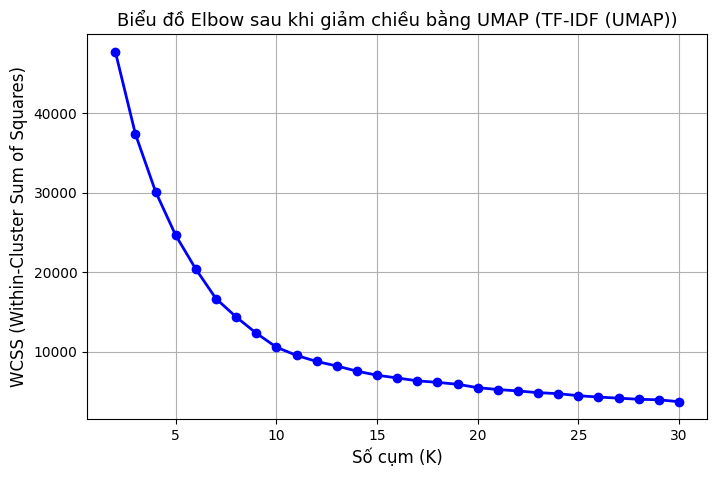

=== Giá trị WCSS (TF-IDF (UMAP)) ===
K = 2  WCSS = 47723.77
K = 3  WCSS = 37344.94
K = 4  WCSS = 30120.54
K = 5  WCSS = 24627.80
K = 6  WCSS = 20382.71
K = 7  WCSS = 16674.90
K = 8  WCSS = 14372.14
K = 9  WCSS = 12332.47
K = 10 WCSS = 10571.76
K = 11 WCSS = 9537.83
K = 12 WCSS = 8776.94
K = 13 WCSS = 8205.25
K = 14 WCSS = 7557.09
K = 15 WCSS = 7046.91
K = 16 WCSS = 6700.81
K = 17 WCSS = 6342.81
K = 18 WCSS = 6147.07
K = 19 WCSS = 5905.69
K = 20 WCSS = 5481.23
K = 21 WCSS = 5249.19
K = 22 WCSS = 5067.29
K = 23 WCSS = 4851.74
K = 24 WCSS = 4729.09
K = 25 WCSS = 4469.67
K = 26 WCSS = 4299.98
K = 27 WCSS = 4161.24
K = 28 WCSS = 4020.34
K = 29 WCSS = 3954.48
K = 30 WCSS = 3716.86
Thời gian chạy: 10.06 giây
 Đang vẽ biểu đồ Elbow cho PhoBERT-base (UMAP) (shape: (7278, 50))


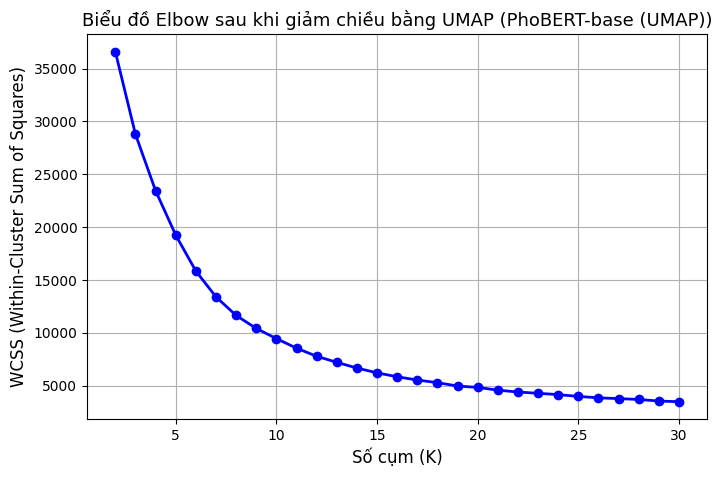

=== Giá trị WCSS (PhoBERT-base (UMAP)) ===
K = 2  WCSS = 36594.86
K = 3  WCSS = 28777.73
K = 4  WCSS = 23436.39
K = 5  WCSS = 19237.79
K = 6  WCSS = 15835.27
K = 7  WCSS = 13391.33
K = 8  WCSS = 11636.08
K = 9  WCSS = 10407.84
K = 10 WCSS = 9444.13
K = 11 WCSS = 8540.38
K = 12 WCSS = 7772.20
K = 13 WCSS = 7200.37
K = 14 WCSS = 6660.53
K = 15 WCSS = 6205.65
K = 16 WCSS = 5831.33
K = 17 WCSS = 5524.40
K = 18 WCSS = 5273.38
K = 19 WCSS = 4958.07
K = 20 WCSS = 4823.87
K = 21 WCSS = 4568.11
K = 22 WCSS = 4388.18
K = 23 WCSS = 4268.32
K = 24 WCSS = 4142.56
K = 25 WCSS = 3974.36
K = 26 WCSS = 3838.47
K = 27 WCSS = 3764.40
K = 28 WCSS = 3687.51
K = 29 WCSS = 3532.58
K = 30 WCSS = 3473.44
Thời gian chạy: 9.66 giây
 Đang vẽ biểu đồ Elbow cho PhoBERT-large (UMAP) (shape: (7278, 50))


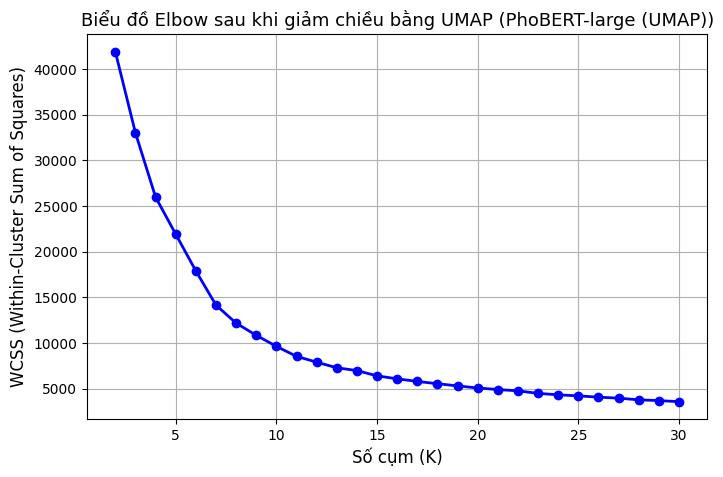

=== Giá trị WCSS (PhoBERT-large (UMAP)) ===
K = 2  WCSS = 41909.49
K = 3  WCSS = 33010.75
K = 4  WCSS = 25973.26
K = 5  WCSS = 21916.95
K = 6  WCSS = 17895.24
K = 7  WCSS = 14144.11
K = 8  WCSS = 12173.38
K = 9  WCSS = 10839.90
K = 10 WCSS = 9631.00
K = 11 WCSS = 8537.38
K = 12 WCSS = 7898.18
K = 13 WCSS = 7282.87
K = 14 WCSS = 6978.57
K = 15 WCSS = 6398.16
K = 16 WCSS = 6072.75
K = 17 WCSS = 5786.72
K = 18 WCSS = 5538.73
K = 19 WCSS = 5296.92
K = 20 WCSS = 5071.83
K = 21 WCSS = 4898.57
K = 22 WCSS = 4757.13
K = 23 WCSS = 4477.89
K = 24 WCSS = 4321.76
K = 25 WCSS = 4205.30
K = 26 WCSS = 4061.75
K = 27 WCSS = 3956.95
K = 28 WCSS = 3770.30
K = 29 WCSS = 3689.75
K = 30 WCSS = 3567.55
Thời gian chạy: 9.35 giây


In [14]:

# === VẼ ELBOW CHO 3 MÔ HÌNH VÀ LƯU KẾT QUẢ ===
wcss_tfidf = plot_elbow_umap(X_tfidf_umap, "TF-IDF (UMAP)", max_k=30)
wcss_base  = plot_elbow_umap(X_base_umap,  "PhoBERT-base (UMAP)", max_k=30)
wcss_large = plot_elbow_umap(X_large_umap, "PhoBERT-large (UMAP)", max_k=30)



### Silhouette

In [15]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import numpy as np
import time

def plot_silhouette_umap(X, name, k_min=2, k_max=30):
    """
    Vẽ biểu đồ Silhouette Score theo số cụm K sau khi giảm chiều bằng UMAP.
    Dùng để chọn K tối ưu cho KMeans.
    """
    print(f"Đang tính Silhouette cho {name} ...")
    X = np.array(X)  # đảm bảo là dense numpy array

    sil_scores = []
    K_range = range(k_min, k_max + 1)

    start_time = time.time()
    for k in K_range:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        labels = kmeans.fit_predict(X)
        sil = silhouette_score(X, labels)
        sil_scores.append(sil)
        print(f"K={k:2d} → Silhouette={sil:.4f}")
    elapsed = time.time() - start_time

    # Xác định K tối ưu
    best_k = K_range[np.argmax(sil_scores)]
    best_sil = max(sil_scores)

    # Vẽ biểu đồ Silhouette
    plt.figure(figsize=(7, 5))
    plt.plot(K_range, sil_scores, 'o-', color='green', linewidth=2, label="Silhouette Score")
    plt.axvline(x=best_k, color='red', linestyle='--', label=f"K tối ưu = {best_k}")
    plt.title(f"Biểu đồ Silhouette sau khi giảm chiều bằng UMAP ({name})", fontsize=13)
    plt.xlabel("Số cụm (K)", fontsize=12)
    plt.ylabel("Silhouette Score", fontsize=12)
    plt.legend()
    plt.grid(True)
    plt.show()

    print(f"{name}: K tối ưu = {best_k} (Silhouette = {best_sil:.4f})")

    return best_k, sil_scores




Đang tính Silhouette cho TF-IDF (UMAP) ...
K= 2 → Silhouette=0.3707
K= 3 → Silhouette=0.3420
K= 4 → Silhouette=0.3021
K= 5 → Silhouette=0.3518
K= 6 → Silhouette=0.3671
K= 7 → Silhouette=0.3908
K= 8 → Silhouette=0.4045
K= 9 → Silhouette=0.4289
K=10 → Silhouette=0.4381
K=11 → Silhouette=0.4400
K=12 → Silhouette=0.4387
K=13 → Silhouette=0.4402
K=14 → Silhouette=0.4515
K=15 → Silhouette=0.4534
K=16 → Silhouette=0.4465
K=17 → Silhouette=0.4342
K=18 → Silhouette=0.4291
K=19 → Silhouette=0.4409
K=20 → Silhouette=0.4350
K=21 → Silhouette=0.4392
K=22 → Silhouette=0.4279
K=23 → Silhouette=0.4215
K=24 → Silhouette=0.4160
K=25 → Silhouette=0.4266
K=26 → Silhouette=0.4351
K=27 → Silhouette=0.4277
K=28 → Silhouette=0.4375
K=29 → Silhouette=0.4146
K=30 → Silhouette=0.4286


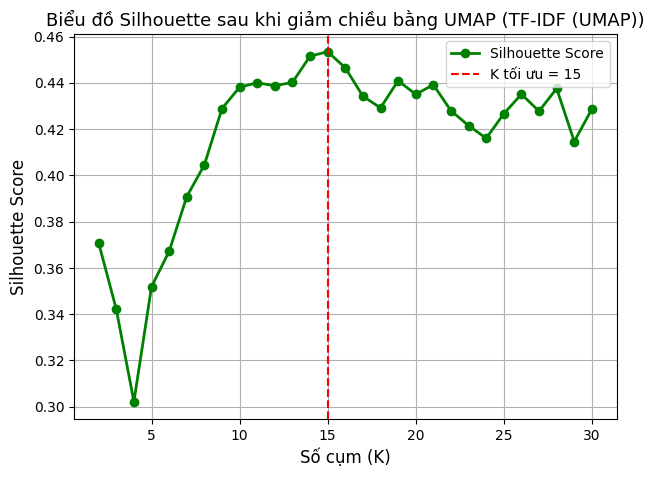

TF-IDF (UMAP): K tối ưu = 15 (Silhouette = 0.4534)
Đang tính Silhouette cho PhoBERT-base (UMAP) ...
K= 2 → Silhouette=0.2375
K= 3 → Silhouette=0.2690
K= 4 → Silhouette=0.2932
K= 5 → Silhouette=0.3262
K= 6 → Silhouette=0.3432
K= 7 → Silhouette=0.3776
K= 8 → Silhouette=0.3996
K= 9 → Silhouette=0.3764
K=10 → Silhouette=0.3729
K=11 → Silhouette=0.3760
K=12 → Silhouette=0.3889
K=13 → Silhouette=0.3972
K=14 → Silhouette=0.4033
K=15 → Silhouette=0.4067
K=16 → Silhouette=0.4078
K=17 → Silhouette=0.4037
K=18 → Silhouette=0.4062
K=19 → Silhouette=0.4090
K=20 → Silhouette=0.3981
K=21 → Silhouette=0.4054
K=22 → Silhouette=0.3921
K=23 → Silhouette=0.3928
K=24 → Silhouette=0.3837
K=25 → Silhouette=0.3748
K=26 → Silhouette=0.3738
K=27 → Silhouette=0.3741
K=28 → Silhouette=0.3789
K=29 → Silhouette=0.3706
K=30 → Silhouette=0.3659


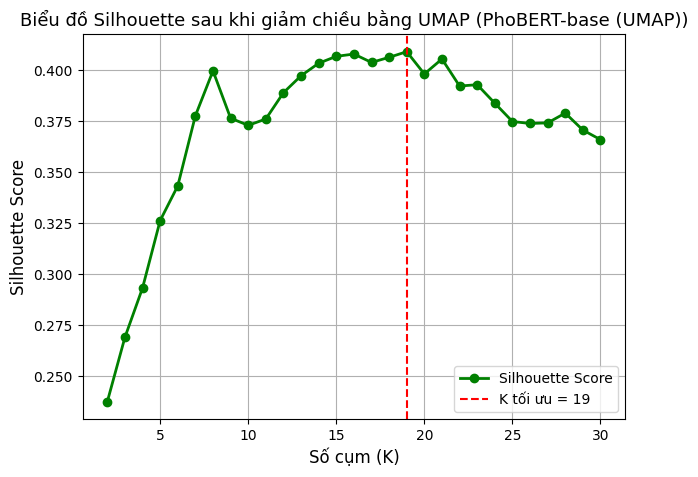

PhoBERT-base (UMAP): K tối ưu = 19 (Silhouette = 0.4090)
Đang tính Silhouette cho PhoBERT-large (UMAP) ...
K= 2 → Silhouette=0.2469
K= 3 → Silhouette=0.3003
K= 4 → Silhouette=0.3225
K= 5 → Silhouette=0.3452
K= 6 → Silhouette=0.3687
K= 7 → Silhouette=0.3979
K= 8 → Silhouette=0.4211
K= 9 → Silhouette=0.4120
K=10 → Silhouette=0.4147
K=11 → Silhouette=0.4115
K=12 → Silhouette=0.4115
K=13 → Silhouette=0.4191
K=14 → Silhouette=0.4165
K=15 → Silhouette=0.4126
K=16 → Silhouette=0.4178
K=17 → Silhouette=0.4140
K=18 → Silhouette=0.4092
K=19 → Silhouette=0.4183
K=20 → Silhouette=0.4113
K=21 → Silhouette=0.3970
K=22 → Silhouette=0.3850
K=23 → Silhouette=0.4116
K=24 → Silhouette=0.3820
K=25 → Silhouette=0.3811
K=26 → Silhouette=0.3794
K=27 → Silhouette=0.3791
K=28 → Silhouette=0.3775
K=29 → Silhouette=0.3803
K=30 → Silhouette=0.3857


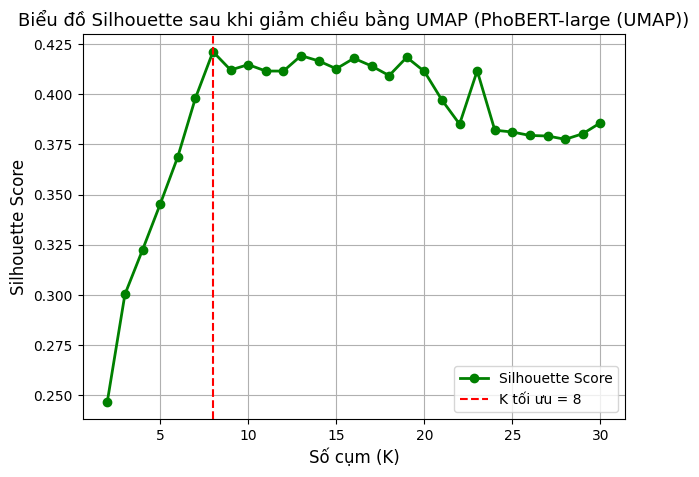

PhoBERT-large (UMAP): K tối ưu = 8 (Silhouette = 0.4211)


In [16]:
# ============================================================
# CHẠY CHO 3 EMBEDDING ĐÃ GIẢM CHIỀU BẰNG UMAP
# ============================================================

best_k_tfidf, sil_tfidf = plot_silhouette_umap(X_tfidf_umap, "TF-IDF (UMAP)", k_min=2, k_max=30)
best_k_base,  sil_base  = plot_silhouette_umap(X_base_umap,  "PhoBERT-base (UMAP)", k_min=2, k_max=30)
best_k_large, sil_large = plot_silhouette_umap(X_large_umap, "PhoBERT-large (UMAP)", k_min=2, k_max=30)


### Elbow và Silhoutte


Sau khi tiến hành giảm chiều dữ liệu bằng UMAP và sử dụng hai phương pháp xác định số cụm tối ưu là Elbow và Silhouette, ta nhận thấy các giá trị K tối ưu giữa hai phương pháp có sự chênh lệch nhẹ. Dựa trên kết quả elbow và Silhouette cho độ tách biệt cụm tốt hơn, nhóm quyết định chọn:

TF-IDF (UMAP): K = 15,

PhoBERT-base (UMAP): K = 19,

PhoBERT-large (UMAP): K = 8.

In [94]:
import matplotlib.pyplot as plt
import numpy as np

def plot_elbow_silhouette_pair(name, wcss, sil_scores, k_min=2):
    """
    Vẽ 2 biểu đồ song song (Elbow và Silhouette) cho 1 embedding
    """
    K_range = range(k_min, k_min + len(wcss))

    plt.figure(figsize=(12, 5))

    # --- Biểu đồ Elbow (bên trái)
    plt.subplot(1, 2, 1)
    plt.plot(K_range, wcss, 'o-', color='blue', linewidth=2)
    plt.title(f"Elbow Method ({name})", fontsize=13)
    plt.xlabel("Số cụm (K)", fontsize=12)
    plt.ylabel("WCSS", fontsize=12)
    plt.grid(True, linestyle="--", alpha=0.5)

    # --- Biểu đồ Silhouette (bên phải)
    plt.subplot(1, 2, 2)
    plt.plot(K_range, sil_scores, 'o-', color='green', linewidth=2)
    plt.axvline(x=K_range[np.argmax(sil_scores)], color='red', linestyle='--',
                label=f"K tối ưu = {K_range[np.argmax(sil_scores)]}")
    plt.title(f"Silhouette Score ({name})", fontsize=13)
    plt.xlabel("Số cụm (K)", fontsize=12)
    plt.ylabel("Silhouette Score", fontsize=12)
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.5)

    plt.tight_layout()
    plt.show()


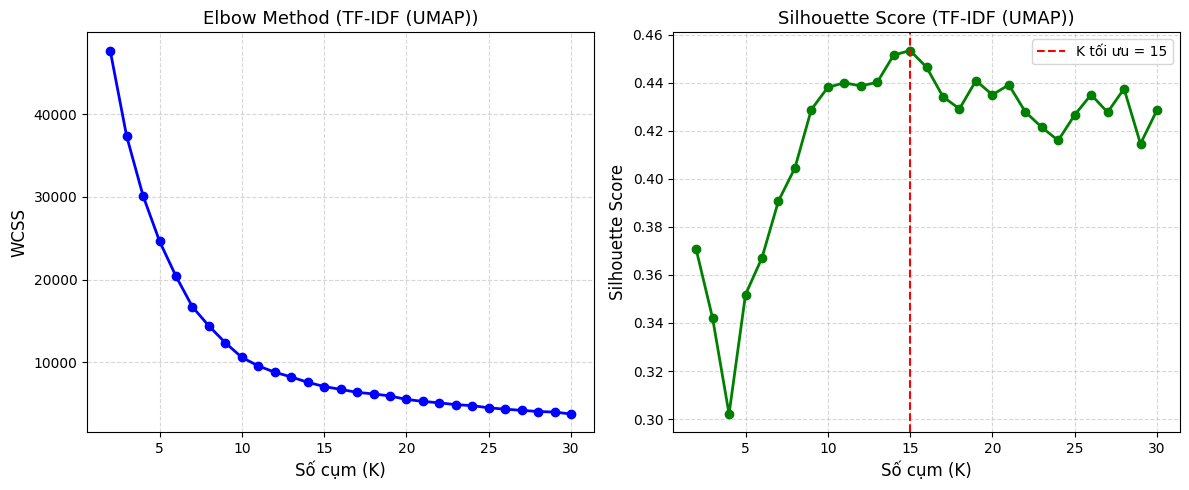

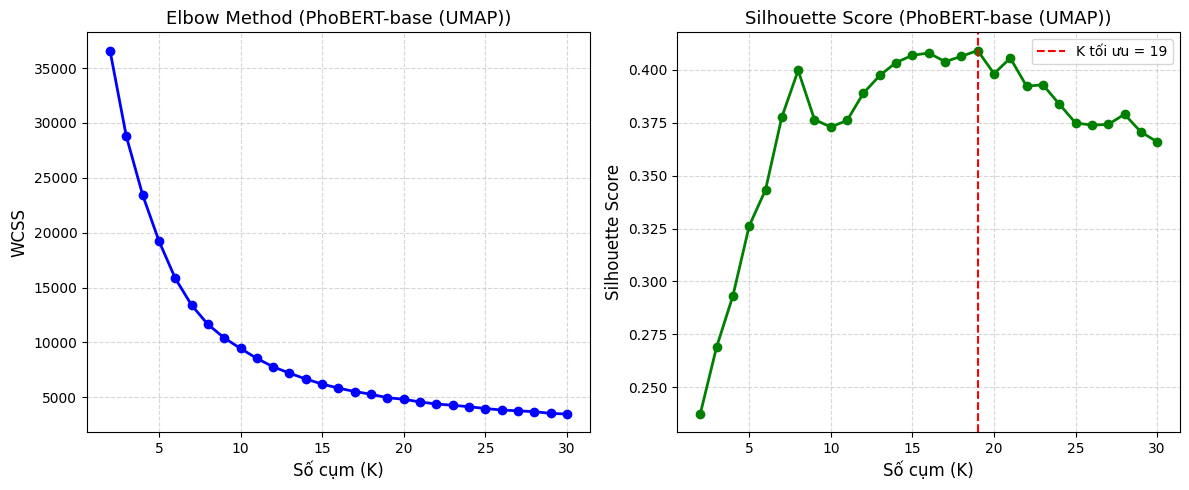

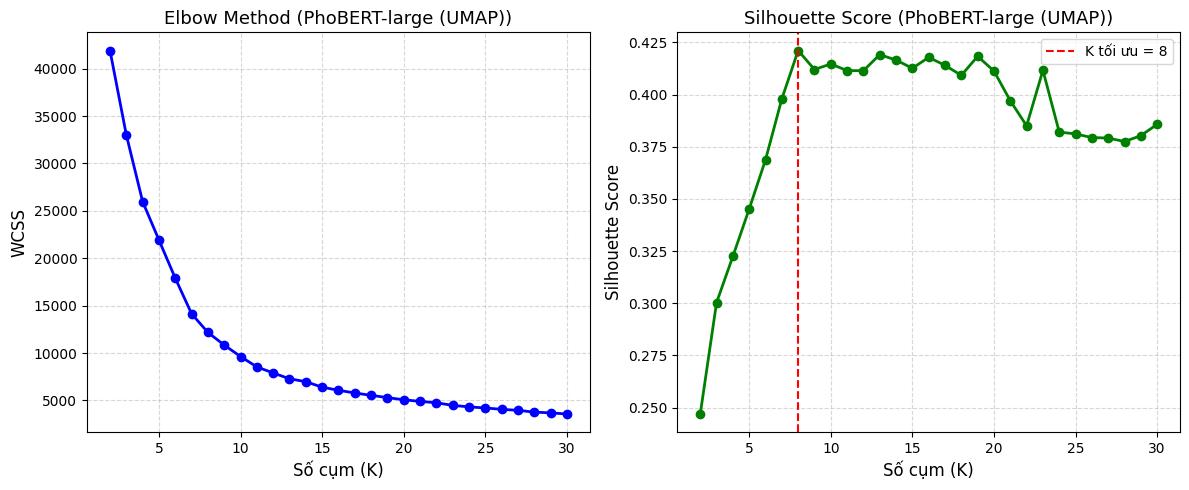

In [95]:
# TF-IDF
plot_elbow_silhouette_pair("TF-IDF (UMAP)", wcss_tfidf, sil_tfidf, k_min=2)

# PhoBERT-base
plot_elbow_silhouette_pair("PhoBERT-base (UMAP)", wcss_base, sil_base, k_min=2)

# PhoBERT-large
plot_elbow_silhouette_pair("PhoBERT-large (UMAP)", wcss_large, sil_large, k_min=2)


### HIERARCHICAL

In [17]:
# =========================================================
# PHÂN CỤM HIERARCHICAL RIÊNG CHO TỪNG EMBEDDING (UMAP)
# =========================================================
import numpy as np
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.cluster import AgglomerativeClustering
import matplotlib.pyplot as plt
from scipy.sparse import issparse, load_npz

# === HÀM PHÂN CỤM HIERARCHICAL ===
def hierarchical_clustering(X, name, n_clusters=5, sample_size=500):
    """
    Phân cụm Hierarchical Clustering cho embedding.
    - X: dữ liệu embedding (TF-IDF hoặc PhoBERT)
    - name: tên mô hình ("TF-IDF", "PhoBERT-base", ...)
    - n_clusters: số cụm cần phân
    - sample_size: số mẫu dùng để vẽ dendrogram
    """
    print(f"Bắt đầu phân cụm Hierarchical cho {name} (K = {n_clusters})")

    # --- Chuyển sparse sang dense (nếu cần)
    X_dense = X.toarray() if issparse(X) else np.array(X)

    # --- Lấy mẫu để vẽ dendrogram cho dễ nhìn
    if X_dense.shape[0] > sample_size:
        idx = np.random.choice(X_dense.shape[0], sample_size, replace=False)
        X_sample = X_dense[idx]
    else:
        X_sample = X_dense

    # --- Tính ma trận liên kết (Ward Linkage)
    linkage_matrix = linkage(X_sample, method="ward")

    # --- Vẽ dendrogram (giới hạn mức để tránh rối)
    plt.figure(figsize=(10, 5))
    dendrogram(linkage_matrix, truncate_mode="level", p=5)
    plt.title(f"Dendrogram ({name}) - Hierarchical Clustering (K={n_clusters})", fontsize=12)
    plt.xlabel("Samples")
    plt.ylabel("Khoảng cách (Distance)")
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.tight_layout()
    plt.show()

    # --- Phân cụm toàn bộ dữ liệu
    model = AgglomerativeClustering(n_clusters=n_clusters, linkage="ward")
    labels = model.fit_predict(X_dense)

    # --- In kết quả phân cụm
    print(f"{name}: Hoàn tất phân cụm với K = {n_clusters}")
    unique, counts = np.unique(labels, return_counts=True)
    for u, c in zip(unique, counts):
        print(f"   - Cụm {u}: {c} văn bản")

    return labels


In [18]:
# =========================================================
# LOAD 3 EMBEDDING (ĐÃ LƯU SAU UMAP)
# =========================================================
path_tfidf = "/content/drive/MyDrive/project2/project2a/X_tfidf_umap.npy"
path_base  = "/content/drive/MyDrive/project2/project2a/embeddings_phobert_base_umap.npy"
path_large = "/content/drive/MyDrive/project2/project2a/embeddings_phobert_large_umap.npy"

print("Đang load TF-IDF (UMAP) ...")
X_tfidf_umap = np.load(path_tfidf)
print("TF-IDF (UMAP) shape:", X_tfidf_umap.shape)

print("Đang load PhoBERT-base (UMAP) ...")
X_base_umap = np.load(path_base)
print("PhoBERT-base (UMAP) shape:", X_base_umap.shape)

print("Đang load PhoBERT-large (UMAP) ...")
X_large_umap = np.load(path_large)
print("PhoBERT-large (UMAP) shape:", X_large_umap.shape)

Đang load TF-IDF (UMAP) ...
TF-IDF (UMAP) shape: (7278, 50)
Đang load PhoBERT-base (UMAP) ...
PhoBERT-base (UMAP) shape: (7278, 50)
Đang load PhoBERT-large (UMAP) ...
PhoBERT-large (UMAP) shape: (7278, 50)


Bắt đầu phân cụm Hierarchical cho TF-IDF (UMAP) (K = 15)


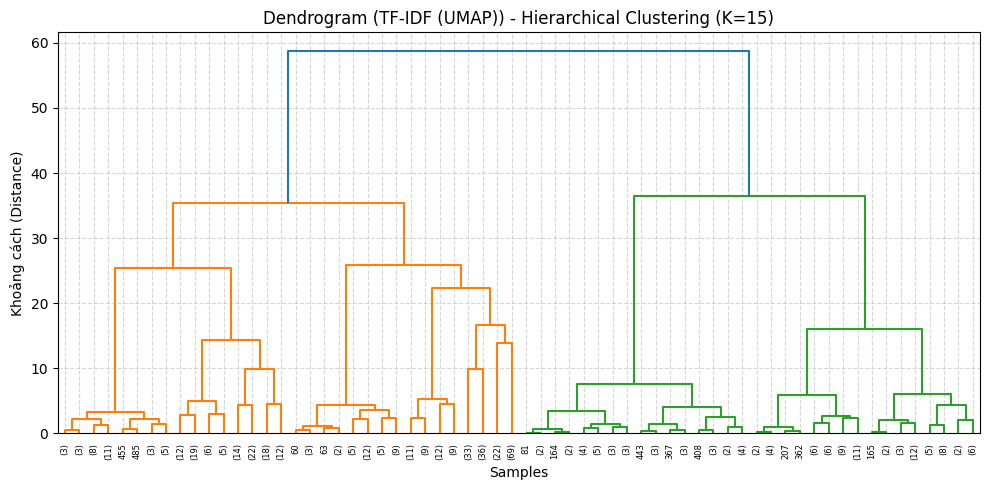

TF-IDF (UMAP): Hoàn tất phân cụm với K = 15
   - Cụm 0: 788 văn bản
   - Cụm 1: 600 văn bản
   - Cụm 2: 540 văn bản
   - Cụm 3: 532 văn bản
   - Cụm 4: 620 văn bản
   - Cụm 5: 616 văn bản
   - Cụm 6: 190 văn bản
   - Cụm 7: 661 văn bản
   - Cụm 8: 290 văn bản
   - Cụm 9: 556 văn bản
   - Cụm 10: 495 văn bản
   - Cụm 11: 489 văn bản
   - Cụm 12: 368 văn bản
   - Cụm 13: 328 văn bản
   - Cụm 14: 205 văn bản
Bắt đầu phân cụm Hierarchical cho PhoBERT-base (UMAP) (K = 19)


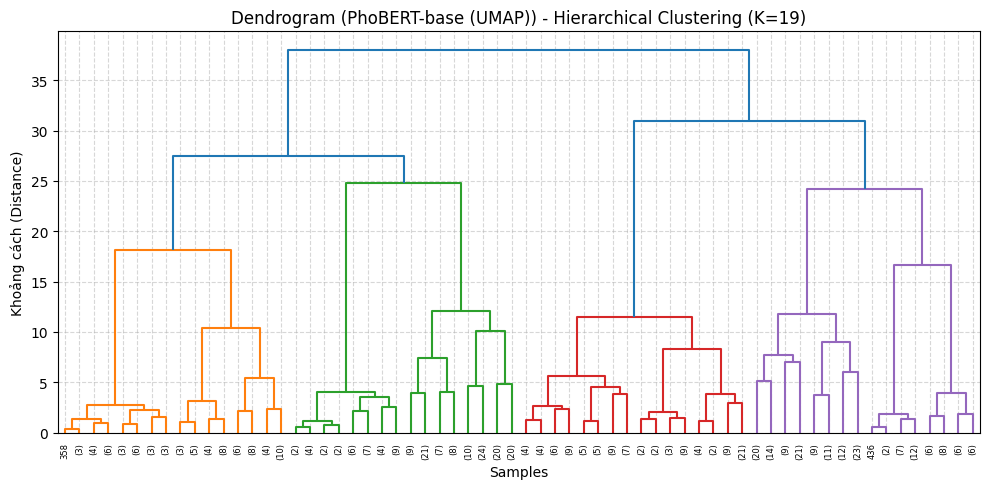

PhoBERT-base (UMAP): Hoàn tất phân cụm với K = 19
   - Cụm 0: 344 văn bản
   - Cụm 1: 646 văn bản
   - Cụm 2: 525 văn bản
   - Cụm 3: 412 văn bản
   - Cụm 4: 435 văn bản
   - Cụm 5: 497 văn bản
   - Cụm 6: 403 văn bản
   - Cụm 7: 250 văn bản
   - Cụm 8: 300 văn bản
   - Cụm 9: 515 văn bản
   - Cụm 10: 514 văn bản
   - Cụm 11: 278 văn bản
   - Cụm 12: 491 văn bản
   - Cụm 13: 365 văn bản
   - Cụm 14: 349 văn bản
   - Cụm 15: 348 văn bản
   - Cụm 16: 149 văn bản
   - Cụm 17: 177 văn bản
   - Cụm 18: 280 văn bản
Bắt đầu phân cụm Hierarchical cho PhoBERT-large (UMAP) (K = 8)


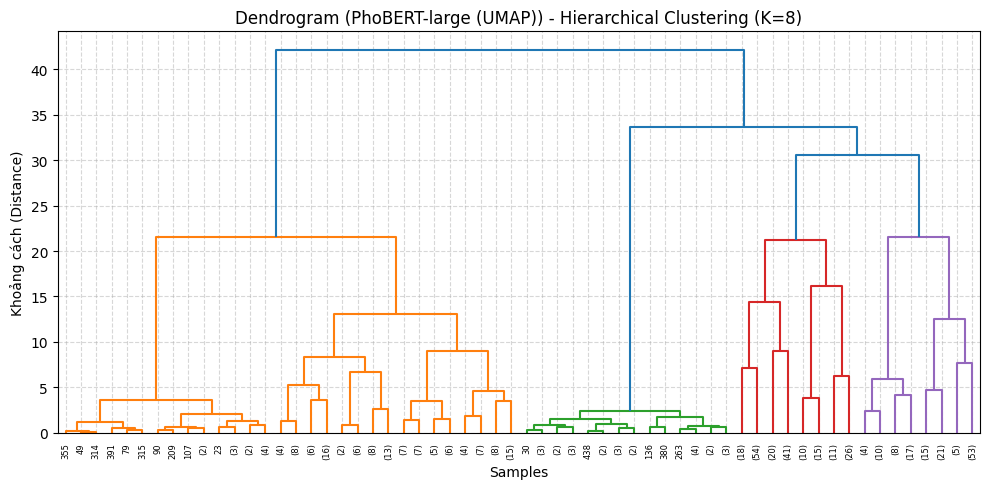

PhoBERT-large (UMAP): Hoàn tất phân cụm với K = 8
   - Cụm 0: 2144 văn bản
   - Cụm 1: 1382 văn bản
   - Cụm 2: 496 văn bản
   - Cụm 3: 1433 văn bản
   - Cụm 4: 549 văn bản
   - Cụm 5: 392 văn bản
   - Cụm 6: 575 văn bản
   - Cụm 7: 307 văn bản


In [19]:

# =========================================================
# PHÂN CỤM RIÊNG CHO TỪNG EMBEDDING
# =========================================================
labels_tfidf = hierarchical_clustering(X_tfidf_umap, "TF-IDF (UMAP)", n_clusters=15)
labels_base  = hierarchical_clustering(X_base_umap,  "PhoBERT-base (UMAP)", n_clusters=19)
labels_large = hierarchical_clustering(X_large_umap, "PhoBERT-large (UMAP)", n_clusters=8)

Silhouette Score cho biết mức độ tách biệt giữa các cụm (giá trị càng cao càng tốt).

Calinski–Harabasz Index phản ánh độ chặt chẽ và tách biệt của các cụm (càng cao càng tốt).

Davies–Bouldin Index đánh giá mức độ tương đồng giữa các cụm (càng thấp càng tốt).
Kết hợp cả ba chỉ số cho phép xác định được mô hình phân cụm có chất lượng ổn định và hợp lý.

In [20]:
# =========================================================
# ĐÁNH GIÁ
# =========================================================
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
import matplotlib.pyplot as plt
import numpy as np

def evaluate_and_plot_umap(X_umap, X_original, labels, name="Model"):
    """
    - X_umap: dữ liệu đã giảm chiều (2D hoặc 3D)
    - X_original: dữ liệu gốc (TF-IDF / PhoBERT embedding, dùng để tính chỉ số)
    - labels: nhãn cụm sau phân cụm
    - name: tên mô hình
    """
    # --- Chuyển sang dense nếu là sparse ---
    X_dense = X_original.toarray() if hasattr(X_original, "toarray") else np.array(X_original)

    # --- Tính 3 chỉ số nội tại ---
    sil = silhouette_score(X_dense, labels)
    ch  = calinski_harabasz_score(X_dense, labels)
    db  = davies_bouldin_score(X_dense, labels)

    print(f"{name} - ĐÁNH GIÁ CHẤT LƯỢNG PHÂN CỤM")
    print(f"   Silhouette Score       : {sil:.4f}  ")
    print(f"   Calinski–Harabasz Index: {ch:.2f}   ")
    print(f"   Davies–Bouldin Index   : {db:.4f}  ")

    # --- Vẽ biểu đồ UMAP ---
    print(f"Vẽ biểu đồ UMAP cho {name} ...")
    plt.figure(figsize=(6, 5))
    plt.scatter(
        X_umap[:, 0], X_umap[:, 1],
        c=labels, cmap='tab20', s=10, alpha=0.8
    )
    plt.title(f"{name} - UMAP Visualization (K={len(np.unique(labels))})", fontsize=12)
    plt.xlabel("UMAP-1")
    plt.ylabel("UMAP-2")
    plt.grid(True, linestyle="--", alpha=0.4)
    plt.tight_layout()
    plt.show()

    return {"silhouette": sil, "calinski": ch, "davies": db}


TF-IDF (Hierarchical) - ĐÁNH GIÁ CHẤT LƯỢNG PHÂN CỤM
   Silhouette Score       : 0.0326  
   Calinski–Harabasz Index: 50.69   
   Davies–Bouldin Index   : 5.8083  
Vẽ biểu đồ UMAP cho TF-IDF (Hierarchical) ...


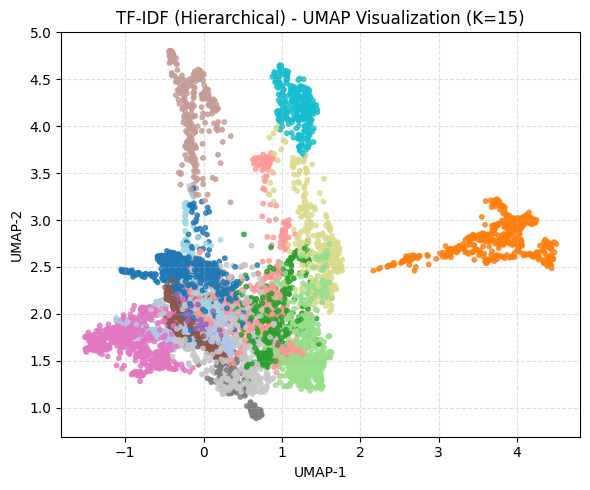

PhoBERT-base (Hierarchical) - ĐÁNH GIÁ CHẤT LƯỢNG PHÂN CỤM
   Silhouette Score       : 0.0436  
   Calinski–Harabasz Index: 108.60   
   Davies–Bouldin Index   : 3.8068  
Vẽ biểu đồ UMAP cho PhoBERT-base (Hierarchical) ...


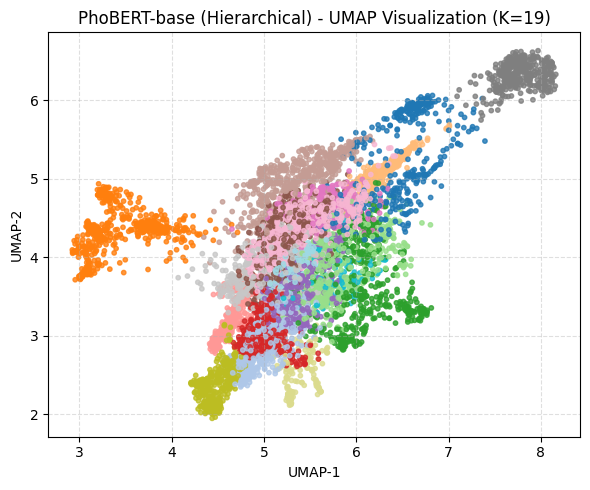

PhoBERT-large (Hierarchical) - ĐÁNH GIÁ CHẤT LƯỢNG PHÂN CỤM
   Silhouette Score       : 0.0278  
   Calinski–Harabasz Index: 215.67   
   Davies–Bouldin Index   : 3.3361  
Vẽ biểu đồ UMAP cho PhoBERT-large (Hierarchical) ...


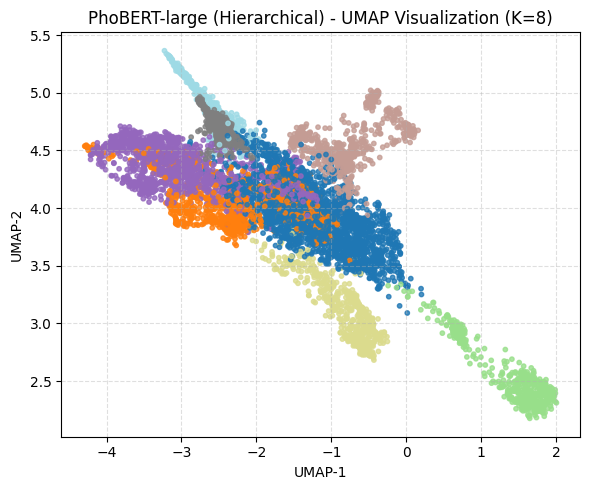

{'silhouette': np.float32(0.027755097),
 'calinski': np.float32(215.6668),
 'davies': np.float64(3.33614835281502)}

In [21]:
# TF-IDF
evaluate_and_plot_umap(X_tfidf_umap, X_tfidf, labels_tfidf, "TF-IDF (Hierarchical)")

# PhoBERT-base
evaluate_and_plot_umap(X_base_umap, embeddings_base, labels_base, "PhoBERT-base (Hierarchical)")

# PhoBERT-large
evaluate_and_plot_umap(X_large_umap, embeddings_large, labels_large, "PhoBERT-large (Hierarchical)")


### KMEANS

In [22]:
# =========================================================
# PHÂN CỤM K-MEANS CHO 3 EMBEDDING (SAU KHI GIẢM CHIỀU UMAP)
# =========================================================
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA

# --- HÀM PHÂN CỤM VÀ ĐÁNH GIÁ ---
def run_kmeans(X, name, n_clusters):
    """
    Chạy KMeans, đánh giá bằng các chỉ số, và vẽ biểu đồ trực quan 2D.
    """
    print(f" Đang chạy K-Means cho {name} (K = {n_clusters}) ...")

    X = np.array(X)
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X)

    # === ĐÁNH GIÁ CHẤT LƯỢNG PHÂN CỤM ===
    sil = silhouette_score(X, labels)
    dbi = davies_bouldin_score(X, labels)
    ch = calinski_harabasz_score(X, labels)

    print(f"{name} — KMeans (K={n_clusters}):")
    print(f"   Silhouette Score:        {sil:.4f}")
    print(f"   Davies-Bouldin Index:    {dbi:.4f}")
    print(f"   Calinski-Harabasz Index: {ch:.2f} ")

    # === TRỰC QUAN HÓA 2D BẰNG PCA ===
    pca = PCA(n_components=2, random_state=42)
    X_pca = pca.fit_transform(X)

    plt.figure(figsize=(6, 5))
    plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap="tab20", s=10, alpha=0.8)
    plt.title(f"K-Means Clustering ({name}) - K={n_clusters}", fontsize=13)
    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")
    plt.colorbar(label="Cluster ID")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return labels, {"silhouette": sil, "dbi": dbi, "ch": ch}



 Đang chạy K-Means cho TF-IDF (UMAP) (K = 15) ...
TF-IDF (UMAP) — KMeans (K=15):
   Silhouette Score:        0.4534
   Davies-Bouldin Index:    0.8917
   Calinski-Harabasz Index: 4710.54 


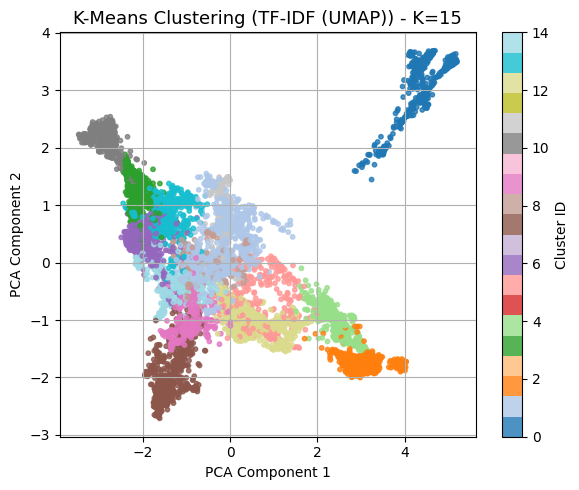

 Đang chạy K-Means cho PhoBERT-base (UMAP) (K = 19) ...
PhoBERT-base (UMAP) — KMeans (K=19):
   Silhouette Score:        0.4090
   Davies-Bouldin Index:    0.8814
   Calinski-Harabasz Index: 3531.94 


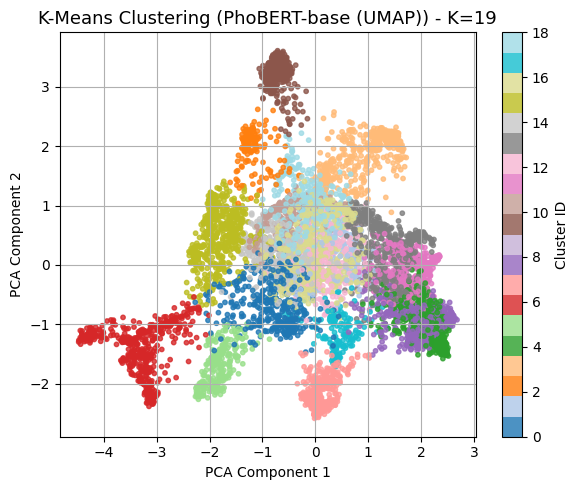

 Đang chạy K-Means cho PhoBERT-large (UMAP) (K = 8) ...
PhoBERT-large (UMAP) — KMeans (K=8):
   Silhouette Score:        0.4211
   Davies-Bouldin Index:    0.8684
   Calinski-Harabasz Index: 3797.48 


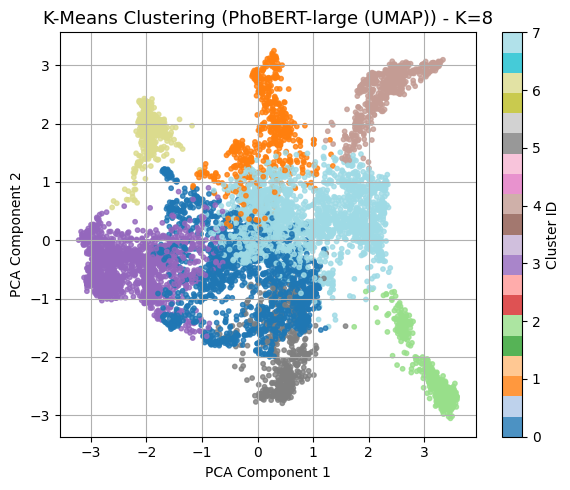

In [24]:
# =========================================================
# CHẠY K-MEANS CHO 3 EMBEDDING ĐÃ GIẢM CHIỀU BẰNG UMAP
# =========================================================
k_tfidf = 15   # TF-IDF (UMAP)
k_base  = 19   # PhoBERT-base (UMAP)
k_large = 8   # PhoBERT-large (UMAP)

labels_tfidf, scores_tfidf = run_kmeans(X_tfidf_umap, "TF-IDF (UMAP)", k_tfidf)
labels_base,  scores_base  = run_kmeans(X_base_umap,  "PhoBERT-base (UMAP)", k_base)
labels_large, scores_large = run_kmeans(X_large_umap, "PhoBERT-large (UMAP)", k_large)




In [25]:
# =========================================================
# TỔNG HỢP KẾT QUẢ
# =========================================================
import pandas as pd

summary = pd.DataFrame([
    ["TF-IDF (UMAP)", k_tfidf, scores_tfidf["silhouette"], scores_tfidf["dbi"], scores_tfidf["ch"]],
    ["PhoBERT-base (UMAP)", k_base, scores_base["silhouette"], scores_base["dbi"], scores_base["ch"]],
    ["PhoBERT-large (UMAP)", k_large, scores_large["silhouette"], scores_large["dbi"], scores_large["ch"]]
], columns=["Embedding", "K", "Silhouette", "Davies-Bouldin", "Calinski-Harabasz"])

print("\n===== TỔNG HỢP CHỈ SỐ ĐÁNH GIÁ CÁC EMBEDDING =====")
print(summary)


===== TỔNG HỢP CHỈ SỐ ĐÁNH GIÁ CÁC EMBEDDING =====
              Embedding   K  Silhouette  Davies-Bouldin  Calinski-Harabasz
0         TF-IDF (UMAP)  15    0.453443        0.891723        4710.541992
1   PhoBERT-base (UMAP)  19    0.408990        0.881408        3531.939697
2  PhoBERT-large (UMAP)   8    0.421113        0.868366        3797.483643


### DBSCAN


In [26]:
# =========================================================
#  PHÂN CỤM DBSCAN CHO 3 EMBEDDING (SAU UMAP)
# =========================================================
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

def run_dbscan(X, name, eps=0.5, min_samples=5):
    """
    Phân cụm bằng DBSCAN, đánh giá chất lượng, và trực quan hóa PCA.
    """
    print(f"Đang chạy DBSCAN cho {name} (eps={eps}, min_samples={min_samples}) ...")
    X = np.array(X)

    # --- Phân cụm ---
    dbscan = DBSCAN(eps=eps, min_samples=min_samples, metric="euclidean", n_jobs=-1)
    labels = dbscan.fit_predict(X)

    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    noise_ratio = np.sum(labels == -1) / len(labels)

    print(f" Số cụm tìm được: {n_clusters}")
    print(f" Tỷ lệ nhiễu (noise): {noise_ratio:.2%}")

    # --- Nếu có ít hơn 2 cụm thì không thể tính chỉ số ---
    if n_clusters < 2:
        print(f" {name}: Không đủ cụm để tính chỉ số đánh giá.")
        return labels, {"silhouette": np.nan, "dbi": np.nan, "ch": np.nan}

    # --- ĐÁNH GIÁ CHẤT LƯỢNG PHÂN CỤM ---
    sil = silhouette_score(X, labels)
    dbi = davies_bouldin_score(X, labels)
    ch = calinski_harabasz_score(X, labels)

    print(f"{name} — DBSCAN:")
    print(f"    Silhouette Score:        {sil:.4f}")
    print(f"    Davies-Bouldin Index:    {dbi:.4f} (càng thấp càng tốt)")
    print(f"    Calinski-Harabasz Index: {ch:.2f} (càng cao càng tốt)")

    # --- TRỰC QUAN HÓA 2D ---
    pca = PCA(n_components=2, random_state=42)
    X_pca = pca.fit_transform(X)

    plt.figure(figsize=(6, 5))
    plt.scatter(
        X_pca[:, 0], X_pca[:, 1],
        c=labels, cmap="tab20", s=10, alpha=0.8
    )
    plt.title(f"DBSCAN Clustering ({name}) - eps={eps}, min_samples={min_samples}", fontsize=13)
    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")
    plt.colorbar(label="Cluster ID")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return labels, {"silhouette": sil, "dbi": dbi, "ch": ch}





Đang chạy DBSCAN cho TF-IDF (UMAP) (eps=0.7, min_samples=70) ...
 Số cụm tìm được: 14
 Tỷ lệ nhiễu (noise): 10.28%
TF-IDF (UMAP) — DBSCAN:
    Silhouette Score:        0.3120
    Davies-Bouldin Index:    1.2622 (càng thấp càng tốt)
    Calinski-Harabasz Index: 2480.17 (càng cao càng tốt)


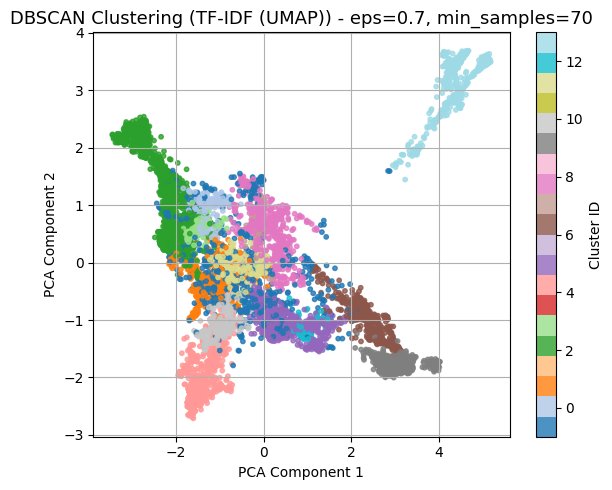

Đang chạy DBSCAN cho PhoBERT-base (UMAP) (eps=0.6, min_samples=60) ...
 Số cụm tìm được: 17
 Tỷ lệ nhiễu (noise): 16.45%
PhoBERT-base (UMAP) — DBSCAN:
    Silhouette Score:        0.2574
    Davies-Bouldin Index:    1.1541 (càng thấp càng tốt)
    Calinski-Harabasz Index: 1866.32 (càng cao càng tốt)


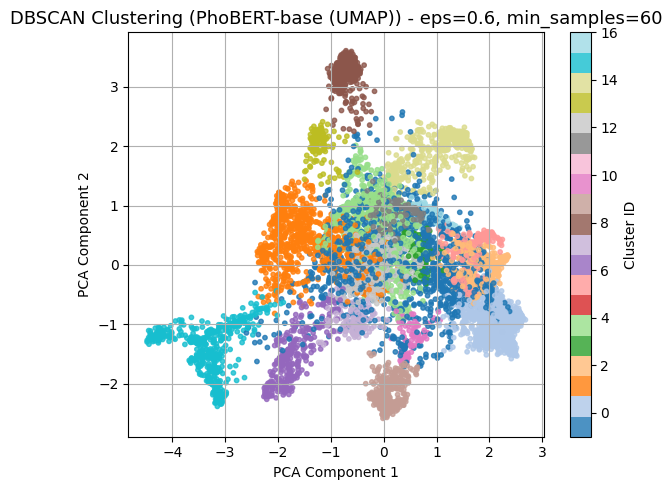

Đang chạy DBSCAN cho PhoBERT-large (UMAP) (eps=0.7, min_samples=70) ...
 Số cụm tìm được: 9
 Tỷ lệ nhiễu (noise): 7.24%
PhoBERT-large (UMAP) — DBSCAN:
    Silhouette Score:        0.2262
    Davies-Bouldin Index:    1.3783 (càng thấp càng tốt)
    Calinski-Harabasz Index: 2189.11 (càng cao càng tốt)


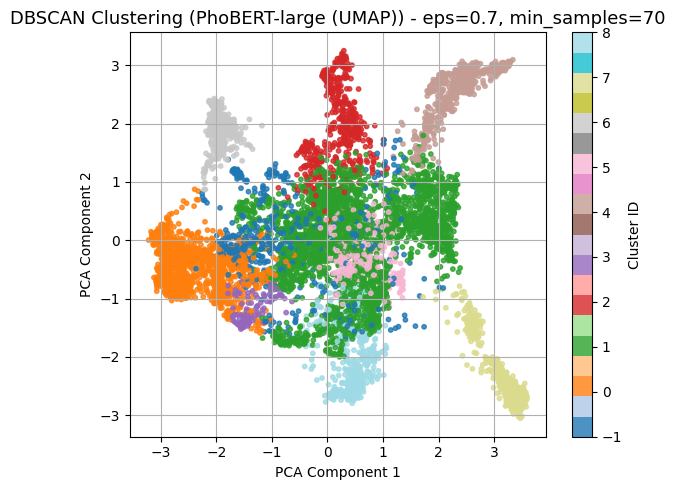

In [51]:
# =========================================================
# CHẠY DBSCAN CHO 3 EMBEDDING ĐÃ GIẢM CHIỀU BẰNG UMAP
# =========================================================
# Tham số nên điều chỉnh nhẹ tuỳ dữ liệu (eps càng nhỏ → cụm càng chi tiết)
params = {
    "TF-IDF (UMAP)":   {"eps": 0.7,  "min_samples": 70},
    "PhoBERT-base":    {"eps": 0.6, "min_samples": 60},
    "PhoBERT-large":   {"eps": 0.7, "min_samples": 70}
}
labels_tfidf_db, scores_tfidf_db = run_dbscan(X_tfidf_umap, "TF-IDF (UMAP)", **params["TF-IDF (UMAP)"])
labels_base_db,  scores_base_db  = run_dbscan(X_base_umap,  "PhoBERT-base (UMAP)", **params["PhoBERT-base"])
labels_large_db, scores_large_db = run_dbscan(X_large_umap, "PhoBERT-large (UMAP)", **params["PhoBERT-large"])



In [52]:
# =========================================================
# TỔNG HỢP CHỈ SỐ ĐÁNH GIÁ
# =========================================================
summary_db = pd.DataFrame([
    ["TF-IDF (UMAP)", params["TF-IDF (UMAP)"]["eps"], params["TF-IDF (UMAP)"]["min_samples"], scores_tfidf_db["silhouette"], scores_tfidf_db["dbi"], scores_tfidf_db["ch"]],
    ["PhoBERT-base (UMAP)", params["PhoBERT-base"]["eps"], params["PhoBERT-base"]["min_samples"], scores_base_db["silhouette"], scores_base_db["dbi"], scores_base_db["ch"]],
    ["PhoBERT-large (UMAP)", params["PhoBERT-large"]["eps"], params["PhoBERT-large"]["min_samples"], scores_large_db["silhouette"], scores_large_db["dbi"], scores_large_db["ch"]]
], columns=["Embedding", "eps", "min_samples", "Silhouette", "Davies-Bouldin", "Calinski-Harabasz"])

print("\n===== TỔNG HỢP CHỈ SỐ ĐÁNH GIÁ DBSCAN =====")
print(summary_db)


===== TỔNG HỢP CHỈ SỐ ĐÁNH GIÁ DBSCAN =====
              Embedding  eps  min_samples  Silhouette  Davies-Bouldin  \
0         TF-IDF (UMAP)  0.7           70    0.312004        1.262238   
1   PhoBERT-base (UMAP)  0.6           60    0.257352        1.154145   
2  PhoBERT-large (UMAP)  0.7           70    0.226215        1.378271   

   Calinski-Harabasz  
0        2480.167725  
1        1866.324463  
2        2189.105713  


### HDBSCAN

In [ ]:
!pip install hdbscan


In [53]:
# ============================================================
# PHÂN CỤM VỚI HDBSCAN CHO 3 EMBEDDING (SAU KHI GIẢM CHIỀU)
# ============================================================

import numpy as np
import hdbscan
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_distances
from sklearn.decomposition import PCA
import time


def run_hdbscan_umap(X, name, min_cluster_size, min_samples, metric='cosine'):
    import numpy as np
    import hdbscan
    import matplotlib.pyplot as plt
    from sklearn.metrics.pairwise import cosine_distances
    from sklearn.decomposition import PCA
    import time

    X = np.array(X)
    print(f"Đang chạy HDBSCAN cho {name} ...")

    start_time = time.time()

    if metric == 'cosine':
        print("→ Đang tính khoảng cách cosine (precomputed)...")
        dist_matrix = cosine_distances(X).astype(np.float64)
        clusterer = hdbscan.HDBSCAN(
            min_cluster_size=min_cluster_size,
            min_samples=min_samples,
            metric='precomputed'
        ).fit(dist_matrix)
    else:
        clusterer = hdbscan.HDBSCAN(
            min_cluster_size=min_cluster_size,
            min_samples=min_samples,
            metric=metric
        ).fit(X)

    elapsed = time.time() - start_time

    labels = clusterer.labels_
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    noise_ratio = np.sum(labels == -1) / len(labels)

    print(f"{name}: Số cụm phát hiện = {n_clusters}")
    print(f"Tỷ lệ điểm nhiễu (noise) = {noise_ratio:.2%}")


    # --- Trực quan hóa bằng PCA 2D ---
    pca = PCA(n_components=2, random_state=42)
    X_pca = pca.fit_transform(X)
    plt.figure(figsize=(6, 5))
    plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='tab20', s=10, alpha=0.7)
    plt.title(f"HDBSCAN Visualization ({name})", fontsize=13)
    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")
    plt.colorbar(label="Cluster ID")
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.show()

    return labels, clusterer






/usr/local/lib/python3.12/dist-packages/hdbscan/robust_single_linkage_.py:175: SyntaxWarning: invalid escape sequence '\{'
  $max \{ core_k(a), core_k(b), 1/\alpha d(a,b) \}$.


Đang chạy HDBSCAN cho TF-IDF (UMAP) ...
→ Đang tính khoảng cách cosine (precomputed)...
TF-IDF (UMAP): Số cụm phát hiện = 15
Tỷ lệ điểm nhiễu (noise) = 29.06%


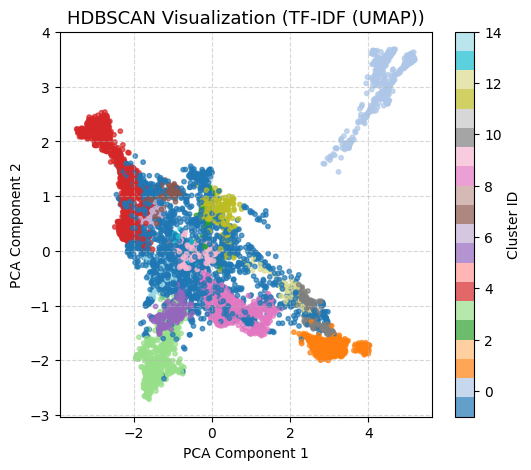

Đang chạy HDBSCAN cho PhoBERT-base (UMAP) ...
→ Đang tính khoảng cách cosine (precomputed)...
PhoBERT-base (UMAP): Số cụm phát hiện = 15
Tỷ lệ điểm nhiễu (noise) = 30.87%


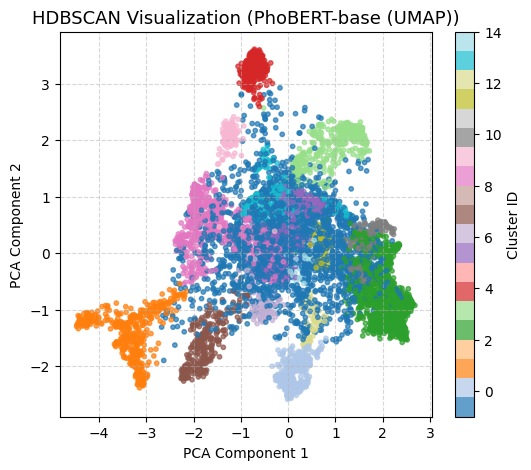

Đang chạy HDBSCAN cho PhoBERT-large (UMAP) ...
→ Đang tính khoảng cách cosine (precomputed)...
PhoBERT-large (UMAP): Số cụm phát hiện = 14
Tỷ lệ điểm nhiễu (noise) = 33.86%


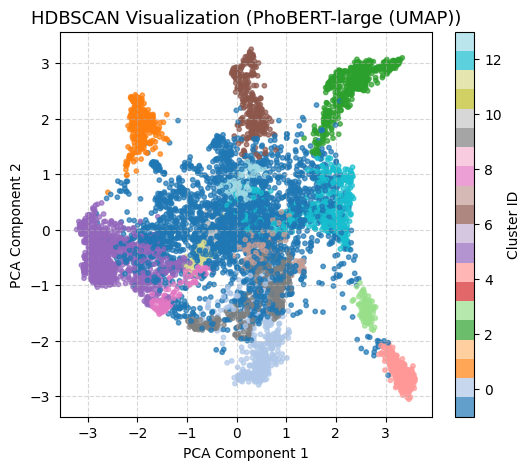

In [89]:
# ============================================================
# CHẠY HDBSCAN CHO CẢ 3 EMBEDDING (ĐÃ GIẢM CHIỀU)
# ============================================================

# TF-IDF (UMAP)
labels_tfidf, model_tfidf = run_hdbscan_umap(
    X_tfidf_umap, "TF-IDF (UMAP)", min_cluster_size=80, min_samples= 50
)

# PhoBERT-base (UMAP)
labels_base, model_base = run_hdbscan_umap(
    X_base_umap, "PhoBERT-base (UMAP)", min_cluster_size=70, min_samples=30
)

# PhoBERT-large (UMAP)
labels_large, model_large = run_hdbscan_umap(
    X_large_umap, "PhoBERT-large (UMAP)", min_cluster_size=80, min_samples=30
)

In [93]:
# =========================================================
#  TỔNG HỢP KẾT QUẢ ĐÁNH GIÁ - HDBSCAN
# =========================================================

from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import pandas as pd

def evaluate_hdbscan(X, labels):
    """Tính các chỉ số đánh giá cho kết quả HDBSCAN."""
    mask = labels != -1  # loại bỏ điểm nhiễu
    if np.sum(mask) < 2:
        return {"silhouette": np.nan, "dbi": np.nan, "ch": np.nan}
    return {
        "silhouette": silhouette_score(X[mask], labels[mask]),
        "dbi": davies_bouldin_score(X[mask], labels[mask]),
        "ch": calinski_harabasz_score(X[mask], labels[mask])
    }

# --- Tính chỉ số cho từng embedding ---
scores_tfidf_hdb = evaluate_hdbscan(X_tfidf_umap, labels_tfidf)
scores_base_hdb = evaluate_hdbscan(X_base_umap, labels_base)
scores_large_hdb = evaluate_hdbscan(X_large_umap, labels_large)

# --- Tổng hợp kết quả ---
summary_hdb = pd.DataFrame([
    ["TF-IDF (UMAP)", len(set(labels_tfidf)) - (1 if -1 in labels_tfidf else 0),
     scores_tfidf_hdb["silhouette"], scores_tfidf_hdb["dbi"], scores_tfidf_hdb["ch"]],
    ["PhoBERT-base (UMAP)", len(set(labels_base)) - (1 if -1 in labels_base else 0),
     scores_base_hdb["silhouette"], scores_base_hdb["dbi"], scores_base_hdb["ch"]],
    ["PhoBERT-large (UMAP)", len(set(labels_large)) - (1 if -1 in labels_large else 0),
     scores_large_hdb["silhouette"], scores_large_hdb["dbi"], scores_large_hdb["ch"]],
], columns=["Embedding", "Số cụm", "Silhouette", "Davies-Bouldin", "Calinski-Harabasz"])

# --- Thêm tỷ lệ nhiễu ---
summary_hdb["Noise (%)"] = [
    np.sum(labels_tfidf == -1) / len(labels_tfidf) * 100,
    np.sum(labels_base == -1) / len(labels_base) * 100,
    np.sum(labels_large == -1) / len(labels_large) * 100
]

print("===== TỔNG HỢP CHỈ SỐ ĐÁNH GIÁ - HDBSCAN =====")
print(summary_hdb)


===== TỔNG HỢP CHỈ SỐ ĐÁNH GIÁ - HDBSCAN =====
              Embedding  Số cụm  Silhouette  Davies-Bouldin  \
0         TF-IDF (UMAP)      15    0.472723        0.764575   
1   PhoBERT-base (UMAP)      15    0.448749        0.709839   
2  PhoBERT-large (UMAP)      14    0.486683        0.669259   

   Calinski-Harabasz  Noise (%)  
0        2721.266602  29.060181  
1        2501.674072  30.873866  
2        3092.031250  33.855455  


### Spectral Clustering

In [90]:
# =========================================================
# PHÂN CỤM VỚI SPECTRAL CLUSTERING (cho 3 embedding)
# =========================================================
from sklearn.cluster import SpectralClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def run_spectral(X, name, n_clusters=10, affinity='nearest_neighbors', n_neighbors=10):
    """
    Thực hiện Spectral Clustering + Đánh giá + Trực quan hóa PCA 2D.
    - X: embedding (TF-IDF hoặc PhoBERT)
    - name: tên embedding
    - n_clusters: số cụm (K)
    - affinity: loại ma trận kề (‘nearest_neighbors’, ‘rbf’, ‘precomputed’)
    """
    print(f"Đang chạy Spectral Clustering cho {name} (K={n_clusters}) ...")
    X = np.array(X)

    # --- Phân cụm ---
    model = SpectralClustering(
        n_clusters=n_clusters,
        affinity=affinity,
        n_neighbors=n_neighbors if affinity == 'nearest_neighbors' else None,
        assign_labels='kmeans',
        random_state=42,
        n_jobs=-1
    )

    labels = model.fit_predict(X)

    # --- Đánh giá ---
    sil = silhouette_score(X, labels)
    dbi = davies_bouldin_score(X, labels)
    ch = calinski_harabasz_score(X, labels)

    print(f"{name}:")
    print(f"   Silhouette Score:        {sil:.4f}")
    print(f"   Davies-Bouldin Index:    {dbi:.4f} ")
    print(f"   Calinski-Harabasz Index: {ch:.2f} ")

    # --- Trực quan hóa bằng PCA ---
    pca = PCA(n_components=2, random_state=42)
    X_pca = pca.fit_transform(X)

    plt.figure(figsize=(6, 5))
    plt.scatter(
        X_pca[:, 0], X_pca[:, 1],
        c=labels, cmap="tab20", s=10, alpha=0.8
    )
    plt.title(f"Spectral Clustering Visualization ({name}, K={n_clusters})", fontsize=13)
    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")
    plt.colorbar(label="Cluster ID")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return labels, {"silhouette": sil, "dbi": dbi, "ch": ch}





Đang chạy Spectral Clustering cho TF-IDF (UMAP) (K=15) ...


/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


TF-IDF (UMAP):
   Silhouette Score:        0.3120
   Davies-Bouldin Index:    0.8360 
   Calinski-Harabasz Index: 2259.86 


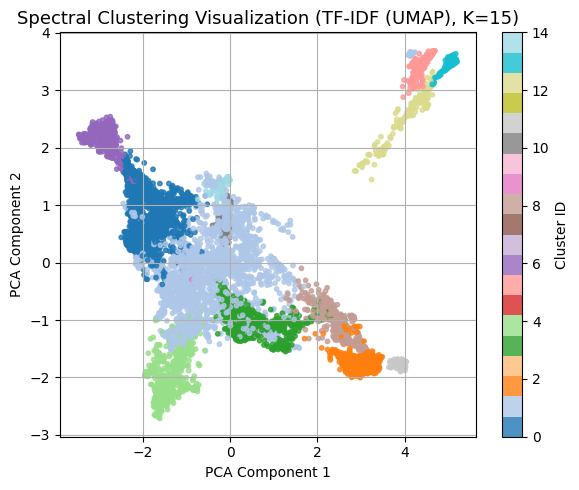

Đang chạy Spectral Clustering cho PhoBERT-base (UMAP) (K=19) ...
PhoBERT-base (UMAP):
   Silhouette Score:        0.2581
   Davies-Bouldin Index:    0.9197 
   Calinski-Harabasz Index: 1861.72 


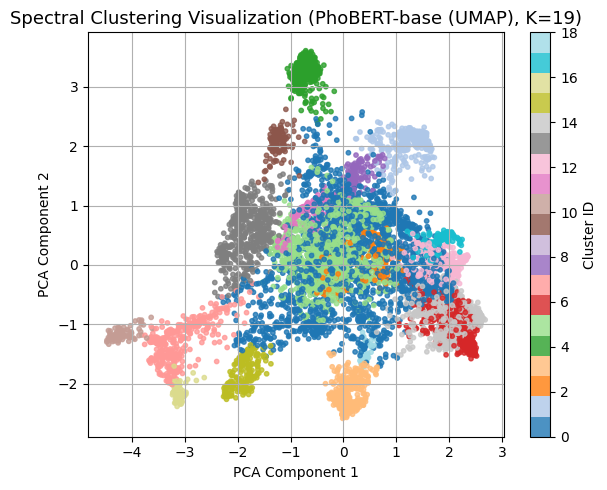

Đang chạy Spectral Clustering cho PhoBERT-large (UMAP) (K=8) ...
PhoBERT-large (UMAP):
   Silhouette Score:        0.3466
   Davies-Bouldin Index:    0.7688 
   Calinski-Harabasz Index: 2416.71 


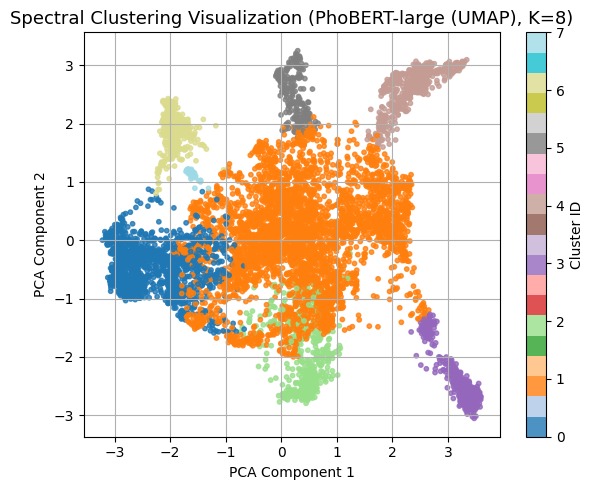

In [91]:

# =========================================================
# CHẠY SPECTRAL CHO 3 EMBEDDING
# =========================================================
# Sử dụng K bạn đã chọn trước đó
K_TFIDF = 15
K_BASE  = 19
K_LARGE = 8

labels_tfidf_sp, scores_tfidf_sp = run_spectral(X_tfidf_umap, "TF-IDF (UMAP)", n_clusters=K_TFIDF)
labels_base_sp,  scores_base_sp  = run_spectral(X_base_umap,  "PhoBERT-base (UMAP)", n_clusters=K_BASE)
labels_large_sp, scores_large_sp = run_spectral(X_large_umap, "PhoBERT-large (UMAP)", n_clusters=K_LARGE)




In [92]:
# =========================================================
#TỔNG HỢP KẾT QUẢ ĐÁNH GIÁ
# =========================================================
summary_sp = pd.DataFrame([
    ["TF-IDF (UMAP)", K_TFIDF, scores_tfidf_sp["silhouette"], scores_tfidf_sp["dbi"], scores_tfidf_sp["ch"]],
    ["PhoBERT-base (UMAP)", K_BASE, scores_base_sp["silhouette"], scores_base_sp["dbi"], scores_base_sp["ch"]],
    ["PhoBERT-large (UMAP)", K_LARGE, scores_large_sp["silhouette"], scores_large_sp["dbi"], scores_large_sp["ch"]]
], columns=["Embedding", "K", "Silhouette", "Davies-Bouldin", "Calinski-Harabasz"])

print("=====TỔNG HỢP CHỈ SỐ ĐÁNH GIÁ - SPECTRAL CLUSTERING =====")
print(summary_sp)

=====TỔNG HỢP CHỈ SỐ ĐÁNH GIÁ - SPECTRAL CLUSTERING =====
              Embedding   K  Silhouette  Davies-Bouldin  Calinski-Harabasz
0         TF-IDF (UMAP)  15    0.311985        0.835960        2259.855469
1   PhoBERT-base (UMAP)  19    0.258113        0.919726        1861.722778
2  PhoBERT-large (UMAP)   8    0.346571        0.768764        2416.707764
